In [1]:
import json

In [3]:
import requests
import geopandas as gpd
import pandas as pd

In [25]:
from bs4 import BeautifulSoup
from shapely.geometry import Point
from tqdm.notebook import tqdm

## Open GIS Data

In [28]:
file_path = "data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
states_df = gpd.read_file(file_path)

## Get Distillery Data

In [16]:
headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"
}
r = requests.get(
    "https://www.distillerytrail.com/distillery-directory-map/", headers=headers
)

In [17]:
soup = BeautifulSoup(r.text, "html.parser")

In [18]:
divs = soup.find_all("div", {"class": "drts-location-entities-map-container"})

In [19]:
div = divs[0]
script = div.find_all("script")[0]

In [20]:
almost_data = script.text.split("setMarkers")[1]

In [21]:
formatted_data_in_str = "}".join(almost_data[2:].split("}")[:-2]) + "}"
formatted_data_in_str = f"[{formatted_data_in_str}]"

In [22]:
distillery_data_list = json.loads(formatted_data_in_str)

Parsing Distilleries:   0%|          | 0/2109 [00:00<?, ?it/s]

{'index': 0, 'entity_id': 17238, 'content': '<div class="drts-bs-card drts-bs-border-0 drts-bs-bg-dark drts-bs-text-white drts-map-marker-content">\n\n<div class="drts-bs-card-img-overlay drts-bs-p-2">\n<div class="drts-bs-card-title"><a href="https://www.distillerytrail.com/directory-distillery/listing/delaware-distilling-company/" class="drts-bs-text-white drts-entity-permalink drts-entity-17238" title="Delaware Distilling Company (Closed)" data-type="post" data-content-type="directory__listing" data-content-name="distillery_dir_ltg">Delaware Distilling Company (Closed)</a></div>\n<address class="drts-map-marker-address drts-bs-card-text">18693 Coastal Hwy, Rehoboth Beach, Delaware 19971, United States</address>\n</div></div>', 'lat': 38.720945, 'lng': -75.076014, 'icon': None}

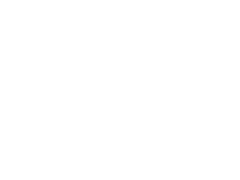

In [29]:
coord_list = []
state_counts = {}
distilleries = []
for distillery in tqdm(distillery_data_list, desc="Parsing Distilleries"):
    point = Point(distillery["lng"], distillery["lat"])
    try:
        state_code = states_df[states_df.intersects(point)]["STUSPS"].iloc[0]
        distilleries.append(point)
    except IndexError:
        print(distillery)
        continue

    if state_code not in state_counts:
        state_counts[state_code] = 1
    else:
        state_counts[state_code] += 1

In [30]:
distilleries_per_state_series = pd.Series(state_counts, name="distilleries")
distilleries_per_state_df = distilleries_per_state_series.reset_index()
distilleries_per_state_df = distilleries_per_state_df.rename(
    columns={"index": "STUSPS"}
)

## Get Brewery Data

In [31]:
url = (
    "https://www.craftbeer.com/wp-content/themes/craftbeer2023/breweries/breweries.json"
)
r = requests.get(url)
breweries_json = r.json()

In [32]:
coord_list = []
state_counts = {}
for brewery in tqdm(breweries_json, desc="Parsing Breweries"):
    if brewery["BillingAddress"]["longitude"] != None:
        point = Point(
            brewery["BillingAddress"]["longitude"],
            brewery["BillingAddress"]["latitude"],
        )
        try:
            state_code = states_df[states_df.intersects(point)]["STUSPS"].iloc[0]
        except IndexError:
            print(brewery["Name"])
            continue
    else:
        state_code = brewery["BillingAddress"]["stateCode"]
        if state_code == None:
            if not brewery["Name"].endswith("Household"):
                print(brewery["Name"])
            continue

    if state_code not in state_counts:
        state_counts[state_code] = 1
    else:
        state_counts[state_code] += 1

Parsing Breweries:   0%|          | 0/14542 [00:00<?, ?it/s]

Tower Brewing
Nickel Brook Brewing Co.
Brewpoint
Cowbell Brewing Co.
kroger
Century Barn Brewing and Beverage Company
H2 BrewHouse
RAM Restaurant and Brewery - Tacoma
Del Barril
Otter Creek Brewing
Crafted
Tallgrass Tap House
Keeper’s Cut Meadery
Orpheus Brewing
Horace Grove Brewery
Platform Beer Co
Arcadia Brewing
Ale Asylum
People’s Republic of South Central
Great Frontier Holdings
ENAY
Sacred Vice Brewing - Howard Street
Colsons Beer
Ecliptic Brewing
Isley Brewing
Dillinger
Honky Tonk Brewing Co
Elk Valley Brewing
Astro-Zombie Bio-Labs
Shebeen Brewing Company
Flying Fish
JuneShine
Griffon & Sphynx
Gun Hill Brewing Company
Deep Ellum Brewing Co
Metropolitan Brewing
Blackberry Farm Brewery
Seldom Beer Co.
Bravazzi
Midway 154 Brewing
Edge Brewing
Peace Tree Brewing


#### Look Up the rest

In [33]:
manually_added = {
    "WA": 1,
    "PR": 1,
    "VT": 1,
    "KS": 1,
    "NC": 2,
    "WI": 1,
    "CA": 2,
    "PA": 1,
    "OR": 1,
    "TN": 2,
    "MD": 1,
    "TX": 1,
    "IL": 2,
    "ID": 1,
}

In [34]:
for state, counts in manually_added.items():
    state_counts[state] += counts

In [35]:
breweries_per_state_series = pd.Series(state_counts, name="breweries")

In [36]:
breweries_per_state_df = breweries_per_state_series.reset_index()
breweries_per_state_df = breweries_per_state_df.rename(columns={"index": "STUSPS"})

## Breweries vs Distilleries

In [39]:
breweries_per_state_df = states_df.merge(
    breweries_per_state_df, on="STUSPS", how="left"
)

In [41]:
breweries_vs_distilleries_df = breweries_per_state_df[
    ["STUSPS", "geometry", "breweries"]
].merge(distilleries_per_state_df[["STUSPS", "distilleries"]], on="STUSPS", how="left")

In [ ]:
breweries_vs_distilleries_df.to_file("data/breweries_vs_distilleries.gpkg")